In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('final_general_data.csv')

In [3]:
len(data)

853624

In [4]:
distribution = data.loc[:, ['recog_conf', 'hmm', 'participant_session']].groupby(['hmm', 'recog_conf']).count()
distribution

participant_session
hmm recog_conf                     
fn  1                         12932
    2                         11778
    3                         11514
    4                          8167
    5                          5436
fp  1                         14754
    2                         10189
    3                          7780
    4                          5192
    5                          6401
tn  1                         24618
    2                         35640
    3                         50824
    4                         59968
    5                         62169
tp  1                         17624
    2                         25699
    3                         48138
    4                         84450
    5                        350351

In [5]:
# Creating the "RAW" section of "Table 1"
raw_new_lure = distribution.loc['tn']
raw_old_lure = distribution.loc['fp']
sum_raw_new_lure = sum(raw_new_lure.values)[0]
sum_raw_old_lure = sum(raw_old_lure.values)[0]
sum_raw_lure = sum_raw_new_lure + sum_raw_old_lure

raw_new_target = distribution.loc['fn']
raw_old_target = distribution.loc['tp']
sum_raw_new_target = sum(raw_new_target.values)[0]
sum_raw_old_target = sum(raw_old_target.values)[0]
sum_raw_target = sum_raw_new_target + sum_raw_old_target

print("Sum of lures (new):",sum_raw_lure)
print("Sum of targets (old):",sum_raw_target)

Sum of lures (new): 277535
Sum of targets (old): 576089


In [6]:
# Creaating the "ALL" section of "Table 1"
all_new_lure = raw_new_lure/sum_raw_lure
all_old_lure = raw_old_lure/sum_raw_lure
sum_all_new_lure = sum(all_new_lure.values)[0]
sum_all_old_lure = sum(all_old_lure.values)[0]
sum_all_lure = sum_all_new_lure + sum_all_old_lure

all_new_target = raw_new_target/sum_raw_target
all_old_target = raw_old_target/sum_raw_target
sum_all_new_target = sum(all_new_target.values)[0]
sum_all_old_target = sum(all_old_target.values)[0]
sum_all_target = sum_all_new_target + sum_all_old_target

print("Sum of lures (new):",sum_all_lure)
print("Sum of targets (old):",sum_all_target)

Sum of lures (new): 1.0
Sum of targets (old): 1.0


In [7]:
# Creaating the "REC" section of "Table 1"
rec_new_lure = raw_new_lure/sum_raw_new_lure
rec_old_lure = raw_old_lure/sum_raw_old_lure
sum_rec_new_lure = sum(rec_new_lure.values)[0]
sum_rec_old_lure = sum(rec_old_lure.values)[0]
sum_rec_lure = sum_rec_new_lure + sum_rec_old_lure

rec_new_target = raw_new_target/sum_raw_new_target
rec_old_target = raw_old_target/sum_raw_old_target
sum_rec_new_target = sum(rec_new_target.values)[0]
sum_rec_old_target = sum(rec_old_target.values)[0]
sum_rec_target = sum_rec_new_target + sum_rec_old_target

print("Sum of lures (new):",sum_rec_lure)
print("Sum of targets (old):",sum_rec_target)

Sum of lures (new): 2.0
Sum of targets (old): 2.0


In [8]:
# Creating "Table 2"
raw_fa = pd.concat([raw_old_lure.iloc[::-1], raw_new_lure ]).cumsum()
raw_hit = pd.concat([raw_old_target.iloc[::-1], raw_new_target ]).cumsum()
all_fa = [0] + list(np.transpose(raw_fa/sum_raw_lure).values[0])
all_hit = [0] + list(np.transpose(raw_hit/sum_raw_target).values[0])

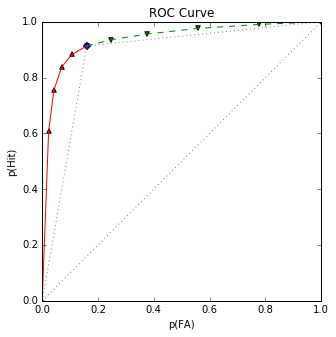

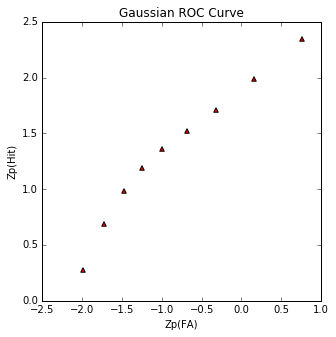

In [9]:
import matplotlib.pyplot as plt
from scipy.stats import norm, linregress
%matplotlib inline

plt.figure(figsize=(5,5))
plt.title('ROC Curve')
plt.xlabel('p(FA)')
plt.ylabel('p(Hit)')
plt.axis(xmin=0, xmax=1, ymin=0, ymax=1)
plt.scatter(all_fa[:5], all_hit[:5], 20, c='r', marker='^')
plt.scatter(all_fa[5:], all_hit[5:], 20, c='g', marker='v')
plt.plot(all_fa[:6], all_hit[:6], c='r')
plt.plot(all_fa[5:], all_hit[5:], c='g', linestyle='--')
plt.plot([0, 1], [0, 1], c='gray', linestyle=':')
plt.plot([0, all_fa[5]], [0, all_hit[5]], c='gray', linestyle=':')
plt.plot([all_fa[5], 1], [all_hit[5], 1], c='gray', linestyle=':')
plt.scatter(all_fa[5], all_hit[5], 25, c='b', marker='D')

plt.figure(figsize=(5,5))
plt.title('Gaussian ROC Curve')
plt.xlabel('Zp(FA)')
plt.ylabel('Zp(Hit)')
#plt.axis(xmin=0, xmax=1, ymin=0, ymax=1)
plt.scatter(list(map(norm.ppf,all_fa)), list(map(norm.ppf,all_hit)), 20, c='r', marker='^')
slope, intercept, _, _, _ = linregress(list(map(norm.ppf,all_fa)), list(map(norm.ppf,all_hit)))

In [11]:
from scipy.integrate import trapz
auc_time_ROC = trapz(all_hit, all_fa)
print(auc_time_ROC)

0.937388315019


In [45]:
# Calculating ROC per participant in order to get d' per participant
from scipy.stats import norm, linregress
from scipy.integrate import trapz
from math import sqrt
from collections import defaultdict

distribution_grouped = data.loc[:, ['recog_conf', 'hmm', 'participant_session', 'participant']].groupby(['participant_session', 'hmm', 'recog_conf']).count()
session_list = list(distribution_grouped.index.levels[0])

participant_session_auc = defaultdict(list)
participant_session_gaussian = defaultdict(list)
for session in session_list:
    raw_new_lure = distribution_grouped.loc[session, 'tn'].reindex([1, 2, 3, 4, 5], fill_value=0, copy=False)
    raw_old_lure = distribution_grouped.loc[session, 'fp'].reindex([1, 2, 3, 4, 5], fill_value=0, copy=False)
    sum_raw_new_lure = sum(raw_new_lure.values)[0]
    sum_raw_old_lure = sum(raw_old_lure.values)[0]
    sum_raw_lure = sum_raw_new_lure + sum_raw_old_lure

    raw_new_target = distribution_grouped.loc[session, 'fn'].reindex([1, 2, 3, 4, 5], fill_value=0, copy=False)
    raw_old_target = distribution_grouped.loc[session, 'tp'].reindex([1, 2, 3, 4, 5], fill_value=0, copy=False)
    sum_raw_new_target = sum(raw_new_target.values)[0]
    sum_raw_old_target = sum(raw_old_target.values)[0]
    sum_raw_target = sum_raw_new_target + sum_raw_old_target
    
    raw_fa = pd.concat([raw_old_lure.iloc[::-1], raw_new_lure ]).cumsum()
    raw_hit = pd.concat([raw_old_target.iloc[::-1], raw_new_target ]).cumsum()
    all_fa = [0] + list(np.transpose(raw_fa/sum_raw_lure).values[0])
    all_hit = [0] + list(np.transpose(raw_hit/sum_raw_target).values[0])
    gaussian_session = [(a,b) for (a,b) in zip(map(norm.ppf, all_fa), map(norm.ppf, all_hit)) if (not np.isinf(a) and not np.isinf(b))]
    
    auc = trapz(all_hit, all_fa)
    participant_session_auc[session[:6]].append(auc)
    participant_session_gaussian[session[:6]].append(np.array(gaussian_session))


participant_auc = { k: np.mean(participant_session_auc[k]) for k in participant_session_auc }
participant_criterion = { k: sqrt(2) * norm.ppf(participant_auc[k]) for k in participant_auc }
participant_regression = dict()
for k in participant_auc:
    slope, intercept, r, _, _ = linregress(np.vstack(participant_session_gaussian[k]))
    participant_regression[k] = (slope, intercept, r**2)

In [11]:
import pickle
pickle.dump(participant_auc, open( "auc_confidence.bin", "wb" ))

In [28]:
participant_criterion

{'LTP063': 2.3829082776863761,
 'LTP064': 2.3522578968672603,
 'LTP065': 2.2643994227110675,
 'LTP066': 1.8333191769827435,
 'LTP067': 2.1359882776395644,
 'LTP069': 2.164743181604754,
 'LTP070': 2.012990116569545,
 'LTP073': 2.8470227575547002,
 'LTP074': 2.4233356601825826,
 'LTP075': 1.64768540941273,
 'LTP076': 2.5920628206078402,
 'LTP077': 1.4860443079686865,
 'LTP079': 3.0650919029736463,
 'LTP081': 2.2947860931874557,
 'LTP082': 3.2831406599195678,
 'LTP084': 0.74795789094082166,
 'LTP085': 2.2266490564812362,
 'LTP086': 1.6783769186906126,
 'LTP087': 1.2406110763650486,
 'LTP088': 1.62910177767459,
 'LTP089': 1.0269114747359067,
 'LTP090': 2.9969358416434506,
 'LTP091': 1.2710042679521716,
 'LTP092': 2.8914971200974744,
 'LTP093': 2.3538149804721047,
 'LTP094': 2.1203730233030953,
 'LTP095': 1.6392616730788345,
 'LTP096': 1.4629847308780526,
 'LTP098': 2.1179231729169157,
 'LTP099': 1.4118207284290039,
 'LTP100': 2.1914606789013527,
 'LTP101': 2.0945321581647689,
 'LTP102': 2.

In [42]:
participant_regression

{'LTP063': (3.7624413810557042, 1.9535127426105425, 0.32895970937275798),
 'LTP064': (1.9457103123583557, 1.9081135247799685, 0.68854483989957005),
 'LTP065': (2.6784790354886145, 1.8468365423521509, 0.44940463616868015),
 'LTP066': (1.8954857027655931, 1.7388073543019895, 0.41636607144438181),
 'LTP067': (1.8451298507347353, 1.9124328194814522, 0.80647692987564445),
 'LTP069': (4.4712265500749204, 1.9049085752395467, 0.18629885963208112),
 'LTP070': (1.6674966401624225, 1.854723129276034, 0.8301853418935996),
 'LTP073': (2.9613027771997604, 2.1651480223856825, 0.43364176000553656),
 'LTP074': (1.9880849184601659, 2.0023013605135498, 0.62729328442736898),
 'LTP075': (1.732652649919503, 1.5203611833820707, 0.73489483316180471),
 'LTP076': (-10.573267170159626, 1.8341206671233248, 0.043706828287922744),
 'LTP077': (4.3700926106839466, 1.5323164947365753, 0.057396470921993237),
 'LTP079': (7.121611404380225, 2.0725015827218347, 0.076407453076011614),
 'LTP081': (1.9228656075282227, 1.9402

(array([  3.,   7.,  19.,  46.,  68.,  28.]),
 array([-0.18700669, -0.02387512,  0.13925645,  0.30238802,  0.46551959,
         0.62865116,  0.79178274]),
 <a list of 6 Patch objects>)

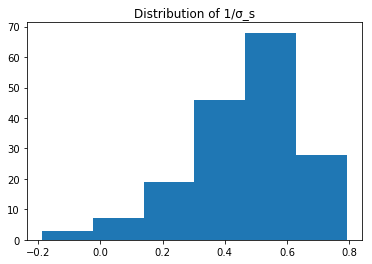

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Distribution of 1/σ_s')
plt.hist(list(map(lambda a: a[0], participant_regression.values())), 6)

(array([  1.,   8.,  24.,  50.,  61.,  27.]),
 array([ 0.57715574,  0.90440646,  1.23165719,  1.55890791,  1.88615864,
         2.21340936,  2.54066009]),
 <a list of 6 Patch objects>)

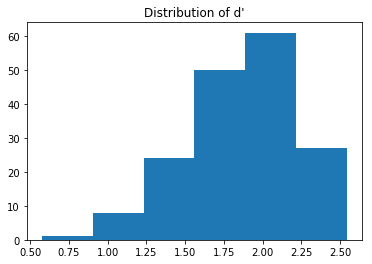

In [40]:
plt.title('Distribution of d\'')
plt.hist(list(map(lambda a: a[1], participant_regression.values())), 6)